# Libraries uploading 

In [1]:
import os

import numpy as np
from numba import njit, prange
from tqdm import tqdm
import scipy
from scipy import signal, sparse

import segyio
import copy

import matplotlib.pyplot as plt
from PIL import Image as im
from PIL import ImageEnhance as ie
from PIL import ImageFilter
%matplotlib inline

# Classes declaration

In [2]:
class CWT:
    def __init__(self, cube_path: str, horizons_path: str):
        self.horizons_path = horizons_path
#         self.cube = segyio.tools.cube(cube_path)[..., 700:1100]
        self.cube = segyio.tools.cube(cube_path)[..., :1100]
        self.horizons, self.surfaces = self.parse_horizons_in_folder()
    def parse_horizons_in_folder(self):
        """
        Считывает файлы горизонтов из фолдера (Charisma dtype).
        :returns: all_horizons (list): Лист NumPy arrays с горизонтами.
        """
        all_horizons = [] 
        try:
            for filename in os.listdir(self.horizons_path):
                file_path = os.path.join(self.horizons_path, filename)  
                if os.path.isfile(file_path): 
                    with open(file_path, "r") as f:
                        horizon = np.loadtxt(f, skiprows=0, usecols=(2,5,8)).astype(np.float32)
                        all_horizons.append(horizon) 
        except FileNotFoundError:
            print(f"Folder '{self.horizons_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)

        surfaces = [self._get_surfaces(horizon) for horizon in all_horizons]

        return all_horizons, surfaces

    @staticmethod
    def _get_surfaces(horizon: np.ndarray) -> np.ndarray:
        """
        Собирает 2D массив горизонта.
        :param horizon: NumPy array с X, Y и Z координатами.
        :return: A 2D NumPy array горизонта.
        """
        min_Y, max_Y = np.min(horizon[:, 1]), np.max(horizon[:, 1])
        min_X, max_X = np.min(horizon[:, 0]), np.max(horizon[:, 0])
        X = np.arange(min_X, max_X, dtype="int32")
        Y = np.arange(min_Y, max_Y, dtype="int32")
        surf = np.empty((X.shape[0], Y.shape[0]))

        for i in range(horizon.shape[0]):
            x_index = (horizon[i, 0] - min_X - 1).astype("int32")
            y_index = (horizon[i, 1] - min_Y - 1).astype("int32")
            surf[x_index, y_index] = horizon[i, 2] / 2

        return np.flip(surf, axis = 0)

    def cwt(self, signal: np.ndarray, wavelet, widths: list, dtype=None, **kwargs) -> np.ndarray:
        """
        Выполняет непрерывное вейвлет-преобразование.
        :param signal: NumPy array сигнала.
        :param wavelet: функция вейвлета (напр. signal.ricker), принимающая 2 аргумента - дрину вейвлета и ширину.
        :param signal: NumPy array сигнала.
        :param width: list ширины для преобразования.

        :return result: NumPy array результата.
        """
        try:
            if dtype is None:
                if np.asarray(wavelet(1, widths[0], **kwargs)).dtype.char in 'FDG':
                    dtype = np.complex64
                else:
                    dtype = np.float32
            result = np.empty((len(widths), len(signal)), dtype=dtype)
            for ind, width in enumerate(widths):
                N = np.min([10 * width, len(signal)])
                wavelet_data = np.flip(np.conj(wavelet(N, width, **kwargs)))
                result[ind] = np.convolve(signal, wavelet_data, mode='same')
            return result
        except Exception as e:
            print(f"Произошла ошибка: {e}")
            return None
    
    def f2w(self, f, bfreq = 500):
        """
        Вычисляет ширину вейвлета в зависимости от частоты.
        :param f: float или np.ndarray, частота.
        :param bfreq: float, базовая частота, по умолчанию равна 500.

        :return: float или np.ndarray, ширина вейвлета.
        """
        try:
            return self._f2w(f, bfreq)
        except Exception as e:
            print(f"Произошла ошибка: {e}")
            return None
        
    @staticmethod
    @njit(fastmath = True)    
    def _f2w(f, bfreq = 500):
        return bfreq/(np.sqrt(2.0)*np.pi*f)
    
    @staticmethod
    def norm_to_rgb_scale(a: np.ndarray, scale: int = 0xff) -> np.ndarray:
        """
        Нормализует входной массив к диапазону от 0 до scale.
        :param a: np.ndarray, входной массив.
        :param scale: int, максимальное значение диапазона, по умолчанию равно 0xff (255, как у изображений).

        :return: np.ndarray, нормализованный массив.
        """
        if not isinstance(a, np.ndarray):
            raise TypeError("Входной параметр 'a' должен быть типа np.ndarray.")
        if not isinstance(scale, int):
            raise TypeError("Входной параметр 'scale' должен быть типа int.")
        try:
            min_a = np.min(a)
            max_a = np.max(a)
            return scale * (a - min_a) / (max_a - min_a)
        except Exception as e:
            print(f"Произошла ошибка: {e}")
            return None

<font size = 3> Вейвлет-анализ по сути сводиться к потрассовой свёртке с вейвлетом определенной частоты (рисунок а). При свёртке в участках, где частота вейвлета и частота сигнала коррелируют, амплитуда на выходе получается выше (зеленая кривая). Соответственно, пробегаясь свёрткой с вейвлетом по кубику можно подсветить аномальные участки. Вейвлеты можно использовать из библиотек scipy.signal или из PyWavelets (в т.ч. Риккера (мексиканская шляпа), Морле и т.п.). Морле - синусоида взвешенная окном хамминга (вроде). В примере ниже частоты берутся 20, 30 и 40 Гц, как ключевые для данной сейсмической записи
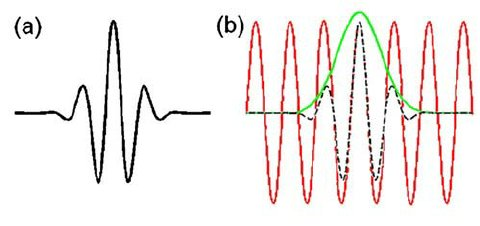

# Calculations

In [3]:
#путь к папке с горизонтами
horizons_path = r"C:\Users\Владислав\Питон\InversionAc\KazanDataAcousticInversion\Inversion_main\horizons"
#путь к кубу
cube_path = r"C:\Users\Владислав\Питон\InversionAc\KazanDataAcousticInversion\Inversion_main\Cub_Kazan.segy"

In [4]:
#путь к папке с горизонтами (формат харизма)
# horizons_path = r"filepath\your_horizons_folder"

In [5]:
#путь к кубику
# cube_path = r"filepath\cube.segy"

In [6]:
CWT = CWT(cube_path, horizons_path) #Иниц. класса 

In [96]:
first_inline = 4018 #первый инлайн для перевода в координаты np.ndarray
inlines = np.rint(CWT.horizons[6][:, 0]).astype(np.int64) - first_inline

first_crline = 694 #первый кросслайн для перевода в координаты np.ndarray
crlines = np.rint(CWT.horizons[6][:, 1]).astype(np.int64) - first_crline

sample_rate = 2 
time_start = 0
flatten_horizon = [(CWT.horizons[i][:, 2] - time_start)/sample_rate for i in range(len(CWT.horizons))]
surfaces_enralged = np.empty(CWT.cube.shape[:2])
surfaces_enralged[inlines, crlines] = np.rint(flatten_horizon[6]).astype(np.int64)


In [97]:
surfaces_enralged[500:, 700]

array([923., 923., 923., ...,   0.,   0.,   0.])

In [98]:
# sum_surf = CWT.surfaces[1]+CWT.surfaces[2]
# mask = (sum_surf >= 700) & (sum_surf <= 1200)
# indices = np.where(mask)
# new_y_6 = copy.deepcopy(CWT.surfaces[5])
# new_y_6[indices] = CWT.surfaces[1][indices]

In [99]:
def interpolate_surfaces(surface, horizon): 
    indices_start = [] 
    indices_end = [] 
    for i in range(surface.shape[0]): 
        folder_start = [] 
        folder_end = [] 
        for j in range(surface.shape[1]): 
            if surface[i, j] != 0: 
                folder_start.append(j) 
        for k in range(surface.shape[1]-1, 0, -1): 
            if surface[i, k] != 0: 
                folder_end.append(k) 
        indices_start.append(folder_start[0]) 
        indices_end.append(folder_end[0]) 
 
    surface1 = np.copy(surface) 
 
    for i in tqdm(range(surface.shape[0])): 
        curve = np.where(horizon[:, 0]-4018 == i) 
        f = Rbf(horizon[curve, 0]-4018,horizon[curve, 1]-694, horizon[curve, 2]/2, normalize=True, epsilon=1, smooth=0.2, shape=20)    
        for j in range(surface.shape[1]): 
            if indices_start[i]<= j <= indices_end[i] and surface[i,j] == 0: 
                surface1[i,j] = f(i, j) 
 
    return surface1, indices_start, indices_end

In [100]:
inlines_new = np.indices(surfaces_enralged.shape)[0].ravel()
crlines_new = np.indices(surfaces_enralged.shape)[1].ravel()
values = surfaces_enralged.ravel()
horizon_new = np.column_stack((inlines_new+4018, crlines_new+694, values))
horizon_new = horizon_new[np.where(horizon_new[:, 2] != 0)]

In [101]:
horizon_new
# CWT.horizons[5]

array([[4018., 1503.,  967.],
       [4018., 1504.,  967.],
       [4018., 1505.,  966.],
       ...,
       [5623., 1053.,  945.],
       [5623., 1054.,  945.],
       [5623., 1055.,  945.]])

In [102]:
mask_2 = surfaces_enralged > 0
indices_2 = np.where(mask_2)
# surfaces_enralged[indices_2] -= 700
surfaces_enralged[indices_2] -= 350

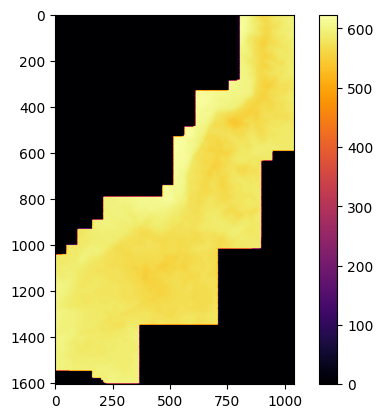

In [103]:
plt.imshow(surfaces_enralged, cmap = "inferno")
# plt.imshow(surfaces_enralged, cmap = "inferno")
plt.colorbar()


In [42]:
surfaces_enralged[100:, 100:]

array([[  0.,   0.,   0., ..., 245.,   0.,   0.],
       [  0.,   0.,   0., ..., 244., 246.,   0.],
       [  0.,   0.,   0., ..., 244.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [16]:
#болванки для r,g,b кубов
cube_r, cube_g, cube_b = np.empty((CWT.cube.shape)), np.empty((CWT.cube.shape)), np.empty((CWT.cube.shape))

In [17]:
#рассчёт r. g. b кубов с помощью непрерывного вейвлет преобразования
for i in tqdm(range(CWT.cube.shape[0])):
    cube_r[i,...] = np.array([np.abs(signal.hilbert(CWT.cwt(trace, signal.ricker, [CWT.f2w(18,500)]))) for trace in CWT.cube[i,...]]).reshape(CWT.cube[i,...].shape)
    cube_g[i,...] = np.array([np.abs(signal.hilbert(CWT.cwt(trace, signal.ricker, [CWT.f2w(30,500)]))) for trace in CWT.cube[i,...]]).reshape(CWT.cube[i,...].shape)
    cube_b[i,...] = np.array([np.abs(signal.hilbert(CWT.cwt(trace, signal.ricker, [CWT.f2w(45,500)]))) for trace in CWT.cube[i,...]]).reshape(CWT.cube[i,...].shape)
        

100%|███████████████████████████████████████████████████████████████████████████████| 1608/1608 [13:47<00:00,  1.94it/s]


In [104]:
# Взятие интервала в окне для визиуализации
window_width = 6 #симметричное окно около горизонта

window_r = np.empty((CWT.cube.shape[0], CWT.cube.shape[1], window_width))
window_g = np.empty((CWT.cube.shape[0], CWT.cube.shape[1], window_width))
window_b = np.empty((CWT.cube.shape[0], CWT.cube.shape[1], window_width))

for ti in tqdm(range(-window_width//2, window_width//2)):
    window_r[inlines, crlines, ti] =  cube_r[inlines, crlines, surfaces_enralged[inlines, crlines].astype(np.int64) + ti]
    window_g[inlines, crlines, ti] =  cube_g[inlines, crlines, surfaces_enralged[inlines, crlines].astype(np.int64) + ti]
    window_b[inlines, crlines, ti] =  cube_b[inlines, crlines, surfaces_enralged[inlines, crlines].astype(np.int64) + ti]

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:58<00:00, 29.76s/it]


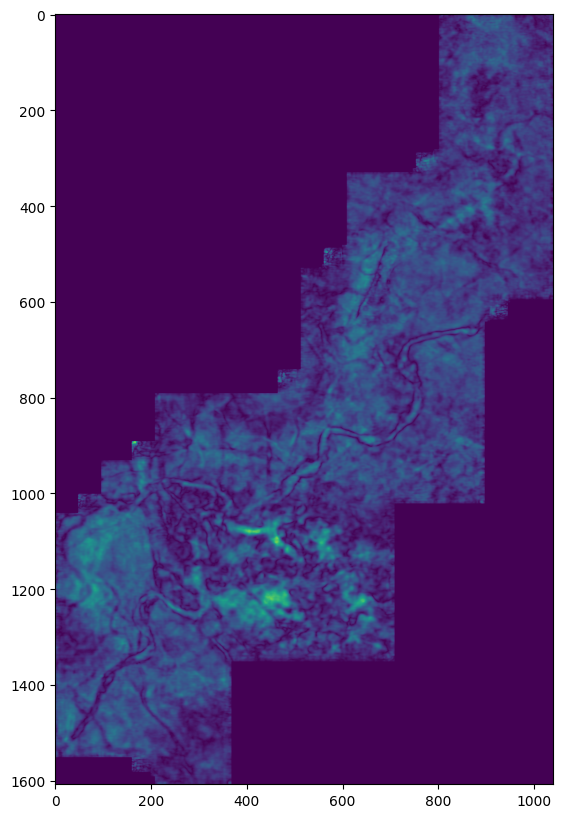

In [91]:
plt.figure(figsize = (10, 10))
plt.imshow(cube_g[:, :,  600])

In [50]:
cube_g.shape

(1608, 1040, 1100)

# Final visualization

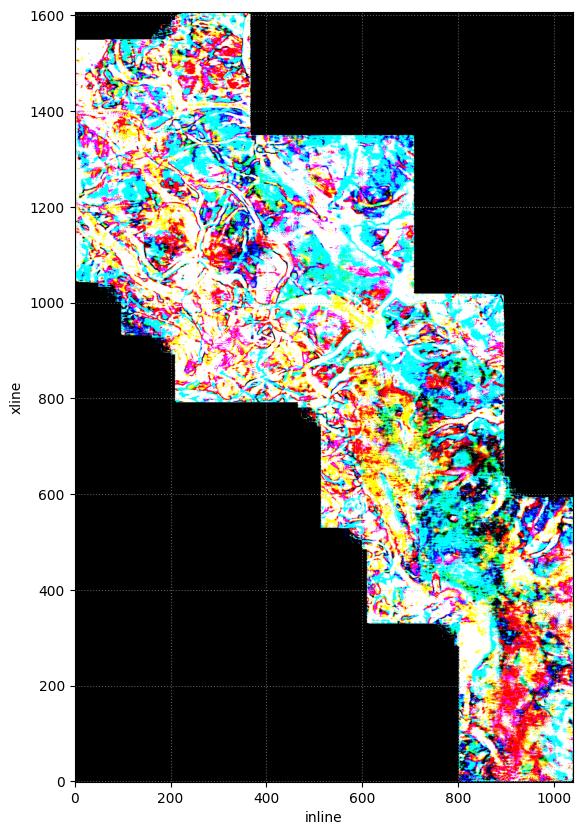

In [59]:
r = CWT.norm_to_rgb_scale(window_r[..., 3]).astype(np.uint8)
g = CWT.norm_to_rgb_scale(window_g[..., 3]).astype(np.uint8)
b = CWT.norm_to_rgb_scale(window_b[..., 3]).astype(np.uint8)

# функция merge позволяет объединить массивы в "изображение"
img = im.merge('RGB', (im.fromarray(r),
                       im.fromarray(g),
                       im.fromarray(b))
              )

factor1 = 10.0 # фактор резкости
factor2 = 1.5 # фактор цветности
factor3 = 5.5 # фактор контраста
factor4 = 5.0 # фактор яркости

# Изменение резкости изображения    
enh = ie.Sharpness(img)
img2 = enh.enhance(factor1)

# Изменение цветности изображения    
enh = ie.Color(img2)
img3 = enh.enhance(factor2)

# Изменение контраста изображения    
enh = ie.Contrast(img3)
img4 = enh.enhance(factor3)

# Изменение яркости изображения    
enh = ie.Brightness(img4)
img5 = enh.enhance(factor4)

plt.figure(figsize = (10, 10))
plt.imshow(img5)
plt.grid(ls=':',alpha=.5)
plt.xlabel('inline')
plt.ylabel('xline')
plt.gca().invert_yaxis()


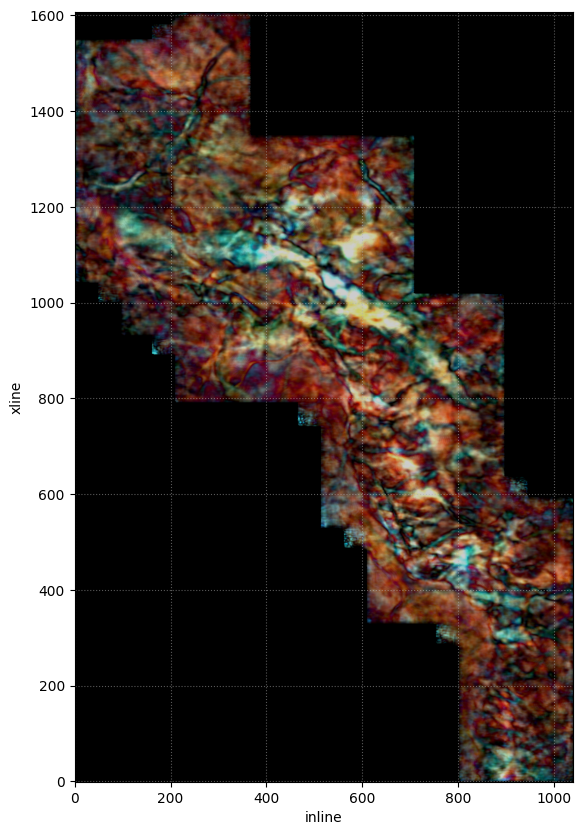

In [114]:
r = CWT.norm_to_rgb_scale(window_r[..., 3]).astype(np.uint8)
g = CWT.norm_to_rgb_scale(window_g[..., 3]).astype(np.uint8)
b = CWT.norm_to_rgb_scale(window_b[..., 3]).astype(np.uint8)

# функция merge позволяет объединить массивы в "изображение"
img = im.merge('RGB', (im.fromarray(r),
                       im.fromarray(g),
                       im.fromarray(b))
              )

factor1 = 1.0 # фактор резкости
factor2 = 0.8 # фактор цветности
factor3 = 2.0 # фактор контраста
factor4 = 0.8 # фактор яркости

# Изменение резкости изображения    
enh = ie.Sharpness(img)
img2 = enh.enhance(factor1)

# Изменение цветности изображения    
enh = ie.Color(img2)
img3 = enh.enhance(factor2)

# Изменение контраста изображения    
enh = ie.Contrast(img3)
img4 = enh.enhance(factor3)

# Изменение яркости изображения    
enh = ie.Brightness(img4)
img5 = enh.enhance(factor4)

plt.figure(figsize = (10, 10))
plt.imshow(img5)
plt.grid(ls=':',alpha=.5)
plt.xlabel('inline')
plt.ylabel('xline')
plt.gca().invert_yaxis()

In [20]:
blended = np.array(img5)

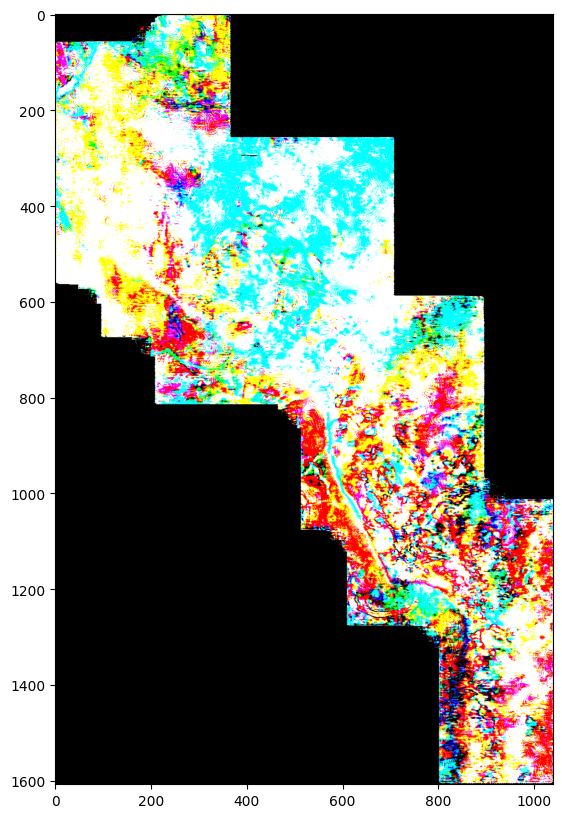

In [21]:
plt.figure(figsize = (10, 10))
plt.imshow(np.flip(blended, axis = 0))

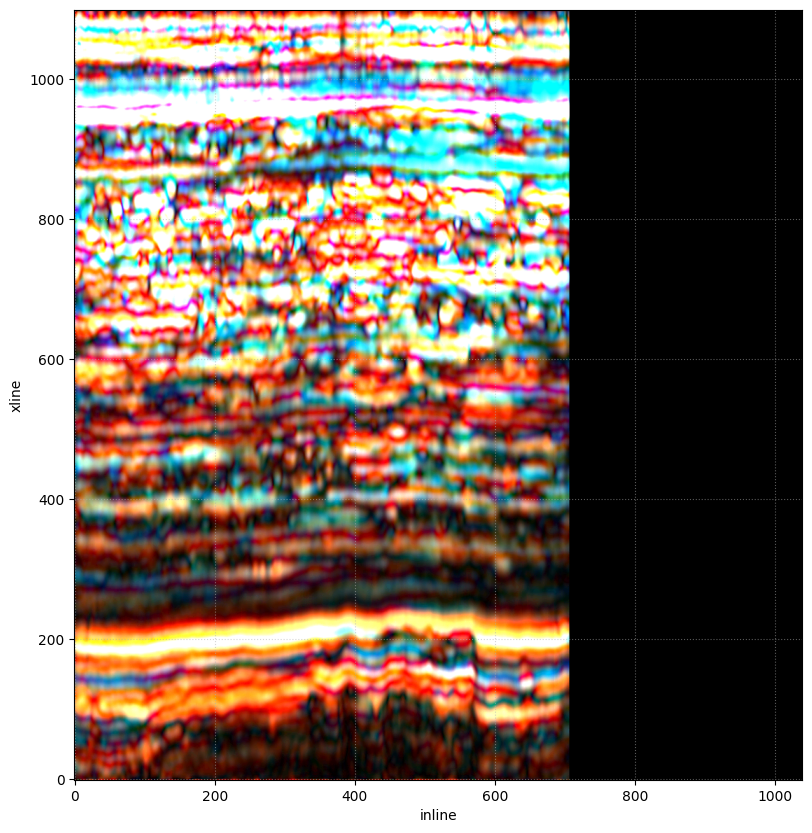

In [22]:
r = CWT.norm_to_rgb_scale(np.flip(cube_r[1100, ...].T, axis = 0)).astype(np.uint8)
g = CWT.norm_to_rgb_scale(np.flip(cube_g[1100, ...].T, axis = 0)).astype(np.uint8)
b = CWT.norm_to_rgb_scale(np.flip(cube_b[1100, ...].T, axis = 0)).astype(np.uint8)

# функция merge позволяет объединить массивы в "изображение"
img = im.merge('RGB', (im.fromarray(r),
                       im.fromarray(g),
                       im.fromarray(b))
              )

factor1 = 2.0 # фактор резкости
factor2 = 1.5 # фактор цветности
factor3 = 1 # фактор контраста
factor4 = 5.0 # фактор яркости

# Изменение резкости изображения    
enh = ie.Sharpness(img)
img2 = enh.enhance(factor1)

# Изменение цветности изображения    
enh = ie.Color(img2)
img3 = enh.enhance(factor2)

# Изменение контраста изображения    
enh = ie.Contrast(img3)
img4 = enh.enhance(factor3)

# Изменение яркости изображения    
enh = ie.Brightness(img4)
img5 = enh.enhance(factor4)

plt.figure(figsize = (10, 10))
plt.imshow(img5)
plt.grid(ls=':',alpha=.5)
plt.xlabel('inline')
plt.ylabel('xline')
plt.gca().invert_yaxis()


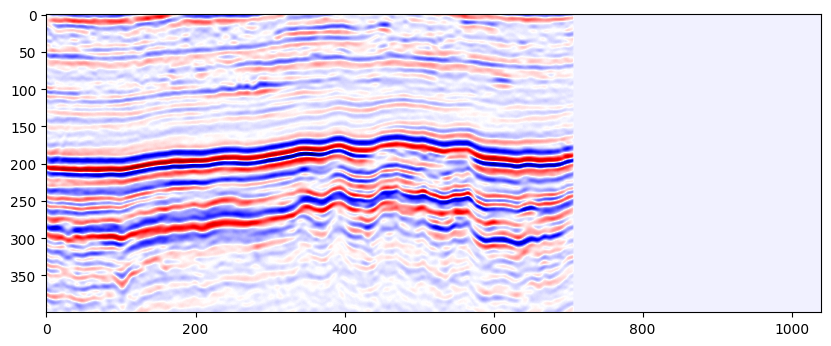

In [377]:
plt.figure(figsize = (10, 10))
plt.imshow(CWT.cube[1100, ...].T, cmap = "seismic")

In [378]:
sample_rate = 0.002 # шаг дискретизации
power = np.fft.rfft(CWT.cube[1100, 200, :].T).real # мощность сигнала
frequency = np.fft.rfftfreq(len(CWT.cube[1100, 200, :].T), sample_rate) # частоты

(0.0, 800.0)

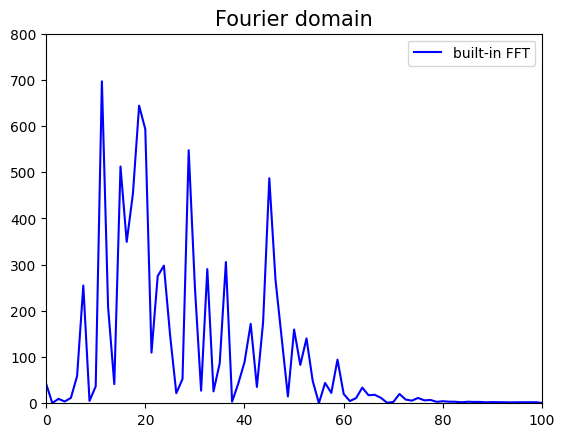

In [384]:
plt.title("Fourier domain", fontsize = 15)
plt.plot(frequency, np.abs(power), "blue", label = "built-in FFT")
plt.legend()
plt.xlim([0, 100])
plt.ylim([0, 800])

In [20]:
pip install scaleogram

Note: you may need to restart the kernel to use updated packages.


In [134]:
# np.savetxt(r"C:\Users\Владислав\Desktop\data_cwt\wavelet_30hz.txt", signal.ricker(500, 30))

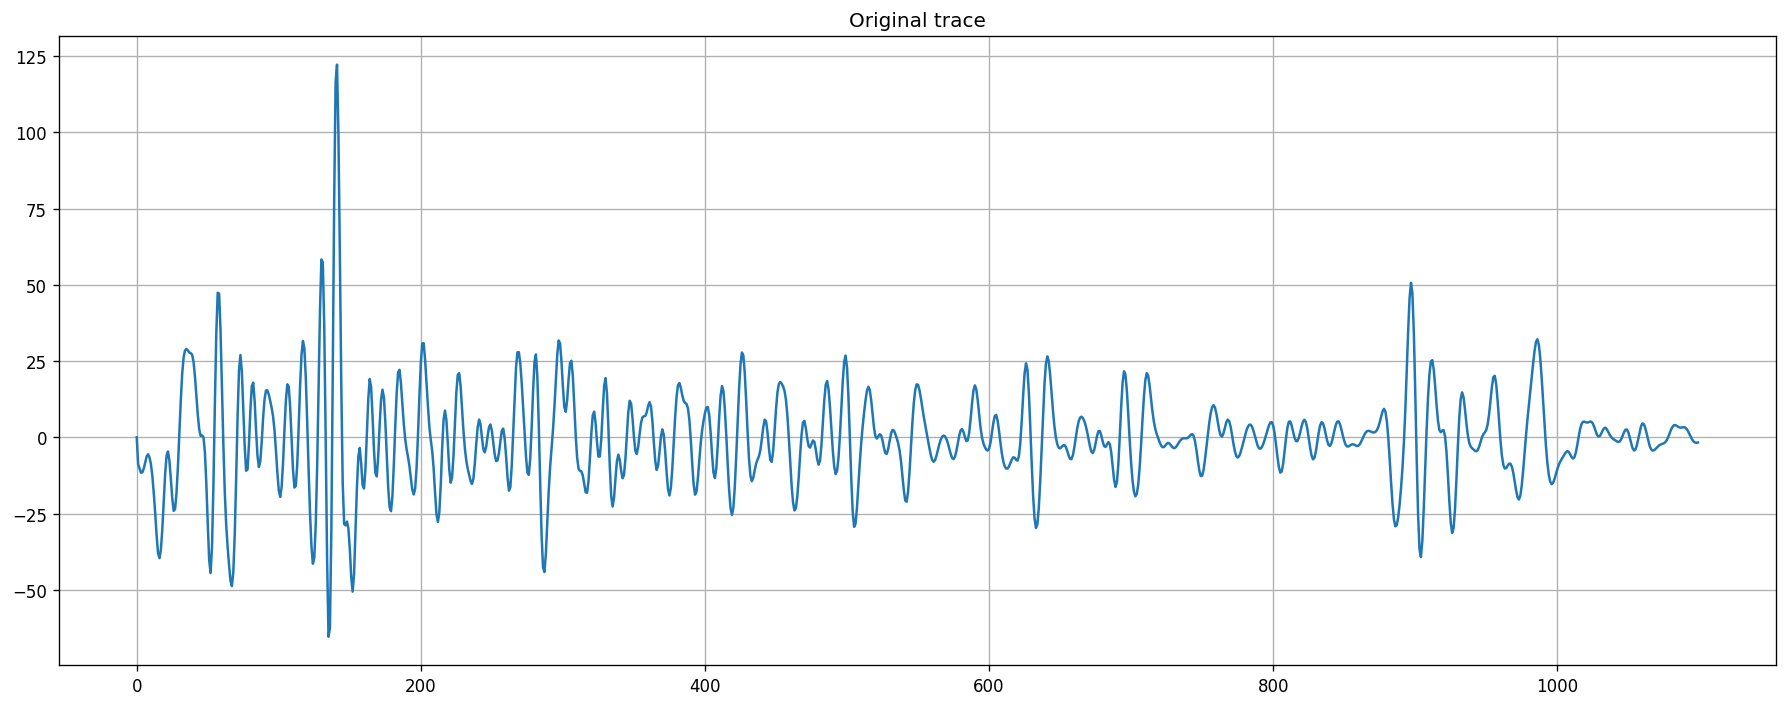

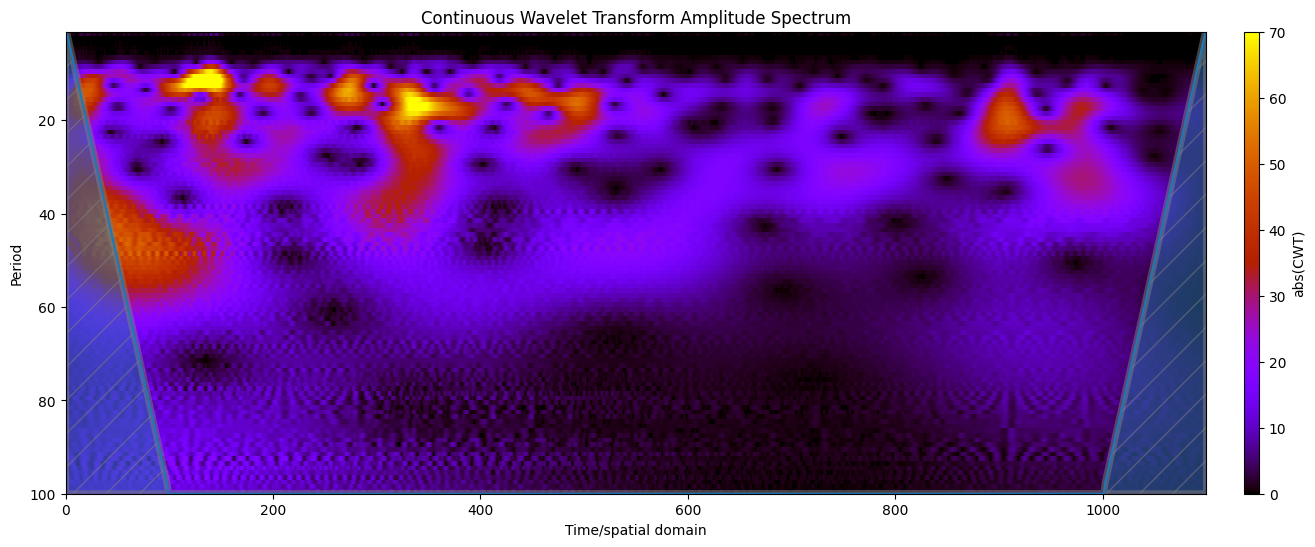

In [82]:
%matplotlib inline
import scaleogram as scg

# Range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, 100))

# Plot the original signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(15, 6), dpi=120)
lines = ax1.plot(CWT.cube[1100, 200, :].T) 
#ax1.set_xlim(0, sr)
ax1.grid()
ax1.set_title("Original trace")
fig1.tight_layout()

# Compute and plot the scaleogram
coikw={'alpha':0.5, 'edgecolor':'gray',
               'hatch':'/', 'linewidth':5, 'cmap':"jet"}
ax2 = scg.cws(CWT.cube[1300, 200, :].T, scales=scales,  figsize=(16, 6), coikw=coikw, clim=(0, 70), cmap = "gnuplot")
# ax2.

In [83]:
import pylops

In [84]:
pylops.Laplacian(500)

<500x500 LinearOperator with dtype=float64>